# Gaia Python Tutorial: Cluster Analysis
*Author: Deborah Baines*

*This tutorial has taken the Gaia Archive tutorial (located at the Gaia Archive, https://archives.esac.esa.int/gaia -> Help -> Tutorials -> Cluster analysis ) and adapted it to python.
The tutorial uses the Gaia TAP+ (astroquery.gaia) module, http://astroquery.readthedocs.io/en/latest/gaia/gaia.html#module-astroquery.gaia .*

*This tutorial is focused on a possible scientific exploration exercise for a known cluster, the Pleiades (M45), using data from the Gaia Archive.*
 
*First, we import all the required python modules:*

In [2]:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

*Do the following to load and look at the available Gaia table names:*

In [4]:
tables = Gaia.load_tables(only_names=True)
for table in (tables):
    print (table.get_qualified_name())

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
external.external.apassdr9
external.external.gaiadr2_astrophysical_parameters
external.external.gaiadr2_geometric_distance
external.external.gaiaedr3_distance
external.external.gaiaedr3_gcns_main_1
external.external.gaiaedr3_gcns_rejected_1
external.external.gaiaedr3_spurious
external.external.galex_ais
external.external.ravedr5_com
external.external.ravedr5_dr5
external.external.ravedr5_gra
external.external.ravedr5_on
external.external.ravedr6
external.external.sdssdr13_photoprimary
external.external.skymapperdr1_master
external.external.skymapperdr2_master
external.external.tmass_xsc
gaiadr1.gaiadr1.aux_qso_icrf2_match
gaiadr1.gaiadr1.ext_phot_zero_point
gaiadr1.gaiadr1.allwise_best_neighbour
gaiadr1.gaiadr1.allwise_neighbourhood
gaiadr1.gaiadr1.gsc23_best_neighbour
gaiadr1.gaiadr1.gsc23_neighbourhood
gaiadr1.gaiadr1.ppmxl_best_neighbour


*Next, we retrieve all the available data in the region of interest. *

*To do this we perform an asynchronous query (asynchronous rather than synchronous queries should be performed when retrieving more than 2000 rows) centred on the Pleides (coordinates: 56.75, +24.1167) with a search radius of 2 degrees and save the results to a file.*

*Note: The query to the archive is with ADQL (Astronomical Data Query Language). For a description of ADQL and more examples see the Gaia DR1 ADQL cookbook: https://gaia.ac.uk/data/gaia-data-release-1/adql-cookbook *

In [21]:
job = Gaia.launch_job_async("SELECT * FROM gaiadr1.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),CIRCLE('ICRS',56.75,24.1167,2))=1;", dump_to_file=True)
print (job)

Jobid: 1685377484824O
Phase: COMPLETED
Owner: None
Output file: 1685377484824O-result.vot.gz
Results: None


*Inspect the output table and number of rows (around 1e5 results are found):*

In [6]:
r = job.get_results()
print (r['source_id'])

    source_id    
-----------------
66926207631181184
66818318054203520
66917823855519360
66830859358837888
66809423175240448
66944761890240000
66980191076373760
66781621852927232
66827805636652928
66947545031024640
              ...
66649989694512256
65666785781176576
64014803920669568
64137880504644992
66542306274948224
64005909043397504
66689881351473664
66436615718993792
65645757620918912
66718434293042560
64103559419447296
Length = 98538 rows


*To identify the cluster, create a proper motion plot of proper motion in RA (pmra) versus proper motion in DEC (pmdec) in the range pmra [-60,80] and pmdec [-120,30]:*

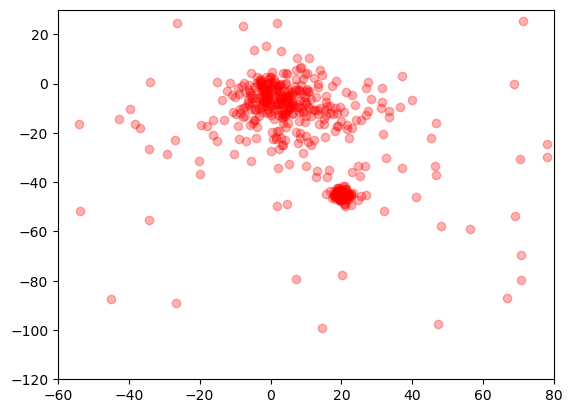

In [7]:
plt.scatter(r['pmra'], r['pmdec'], color='r', alpha=0.3)
plt.xlim(-60,80)
plt.ylim(-120,30)

plt.show()

*Perform another asynchronous query to filter the results by quality:*

In [8]:
job2 = Gaia.launch_job_async("SELECT * \
FROM gaiadr1.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),CIRCLE('ICRS',56.75,24.1167,2))=1 \
AND abs(pmra_error/pmra)<0.10 \
AND abs(pmdec_error/pmdec)<0.10 \
AND pmra IS NOT NULL AND abs(pmra)>0 \
AND pmdec IS NOT NULL AND abs(pmdec)>0;", dump_to_file=True)

*Again, inspect the output table and number of rows:*

In [9]:
j = job2.get_results()
print (j['source_id']) 

    source_id    
-----------------
66623395256627712
66581957412169728
65614730777165824
64053561704835584
65828207832006400
66858862543722112
66863054431798272
66588520122169728
66657823714473856
66592437132341248
              ...
66912360656318208
66471215975411200
66729257611496704
64013704408496896
64013807487711360
66506331628024832
66715101399291392
66724447247218048
66610957031353856
66857281995760000
66570549979009280
Length = 218 rows


*Plot these new filtered results on the same plot as the previous search:*

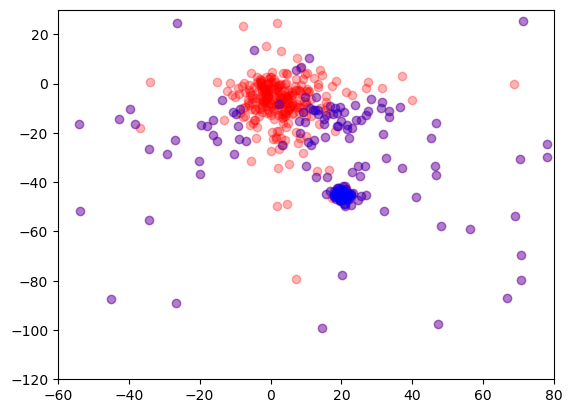

In [10]:
plt.scatter(r['pmra'], r['pmdec'], color='r', alpha=0.3)
plt.scatter(j['pmra'], j['pmdec'], color='b', alpha=0.3)
plt.xlim(-60,80)
plt.ylim(-120,30)

plt.show()

*Now we are going to take the candidate objects to be in the cluster. Based on the proper motion plot, we execute the same job with the following constraints on the proper motions in RA and DEC: pmra between 15 and 25, pmdec between -55 and -40:*

In [11]:
job3 = Gaia.launch_job_async("SELECT * \
FROM gaiadr1.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),CIRCLE('ICRS',56.75,24.1167,2))=1 \
AND abs(pmra_error/pmra)<0.10 \
AND abs(pmdec_error/pmdec)<0.10 \
AND pmra IS NOT NULL AND abs(pmra)>0 \
AND pmdec IS NOT NULL AND abs(pmdec)>0 \
AND pmra BETWEEN 15 AND 25 \
AND pmdec BETWEEN -55 AND -40;", dump_to_file=True)

*Again, inspect the output table and number of rows, and call the job 'm45cluster':*

In [12]:
m45cluster = job3.get_results() 
print (m45cluster['parallax']) 

     parallax     
       mas        
------------------
 7.454564828231018
   7.5239065408351
 6.930109371732377
 7.578892136582589
 7.328286272889863
 7.023364688368016
 8.138967164330523
 8.144555523410178
 7.364846831313057
7.1694418609395765
               ...
  7.28265135413373
 7.468173593228016
 7.658985698496882
7.2023395286122085
  8.29209579454844
  7.14613982210898
 7.836102805006427
7.8762955633015945
 7.066701274479442
7.3330438493994405
Length = 106 rows


*Plot these new filtered results on the same plot as the previous search:*

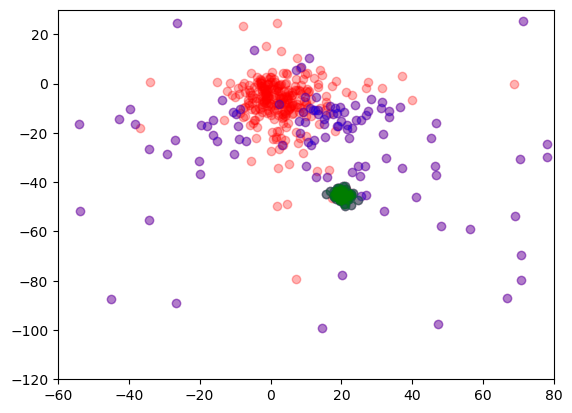

In [13]:
plt.scatter(r['pmra'], r['pmdec'], color='r', alpha=0.3)
plt.scatter(j['pmra'], j['pmdec'], color='b', alpha=0.3)
plt.scatter(m45cluster['pmra'], m45cluster['pmdec'], color='g', alpha=0.3)
plt.xlim(-60,80)
plt.ylim(-120,30)

plt.show()

*Calculate the average parallax and standard deviation of the parallax for the M45 cluster candidates:*

In [14]:
avg_parallax = np.mean(m45cluster['parallax']) 
stddev_parallax = np.std(m45cluster['parallax']) 
print (avg_parallax, stddev_parallax)

7.468669557496789 0.8348227325587293


*Now, we want to add information from other catalogues, in this example from 2MASS. To do this we make use of the pre-computed cross-matched tables provided in the Gaia archive.*

*We obtain the 2MASS photometric data by using the Gaia - 2MASS cross-matched best neighbour table (gaiadr1.tmass_best_neighbour) to identify the sources and the 2MASS original table (gaiadr1.tmass_original_valid) to retrieve the photometry:*

In [15]:
job4 = Gaia.launch_job_async("SELECT * \
FROM gaiadr1.gaia_source AS g, gaiadr1.tmass_best_neighbour AS tbest, gaiadr1.tmass_original_valid AS tmass \
WHERE g.source_id = tbest.source_id AND tbest.tmass_oid = tmass.tmass_oid \
AND CONTAINS(POINT('ICRS',g.ra,g.dec),CIRCLE('ICRS',56.75,24.1167,2))=1 \
AND abs(g.pmra_error/g.pmra)<0.10 \
AND abs(g.pmdec_error/g.pmdec)<0.10 \
AND g.pmra IS NOT NULL AND abs(g.pmra)>0 \
AND g.pmdec IS NOT NULL AND abs(g.pmdec)>0 \
AND g.pmra BETWEEN 15 AND 25 \
AND g.pmdec BETWEEN -55 AND -40;", dump_to_file=False)

INFO: Query finished. [astroquery.utils.tap.core]


*Finally, confirm the output table has Gaia and 2MASS photometry and check the number of rows in the table:*

In [16]:
p = job4.get_results() 
print (p['phot_g_mean_mag', 'j_m', 'h_m', 'ks_m']) 

 phot_g_mean_mag    j_m    h_m   ks_m
       mag          mag    mag   mag 
------------------ ------ ----- -----
10.757800849005008  9.603 9.202 9.094
 6.073301943844488  5.968 6.051 5.976
10.643169127592188  9.535 9.219 9.137
  6.82750238785118  6.699 6.733 6.692
 10.15654586177056  9.117 8.868 8.758
 7.537147252150579   7.28  7.29 7.257
  8.13286526000272  7.588 7.528  7.47
 8.526811916775689  7.892 7.767 7.738
  9.02342350637215  8.236 8.033 8.002
 7.024616005401143  6.848  6.92 6.895
               ...    ...   ...   ...
10.511033521483427  9.477  9.14 9.072
11.597470392962894 10.261 9.835  9.73
10.591447284586406  9.531 9.192 9.123
10.325731863675678   9.35 9.092 8.996
   9.9103711452616  8.983 8.711 8.632
 9.333511794582734  8.533 8.329 8.282
 8.112675586895094  7.673 7.599 7.576
 6.327547776037669  6.228 6.248 6.257
 8.187849825277272  7.526 7.393 7.352
11.149659997470195  9.949 9.564 9.439
Length = 106 rows


All of the above has been performed as an anonymous user to the Gaia archive. To log in to the archive, keep and share your results, see the following instructions: http://astroquery.readthedocs.io/en/latest/gaia/gaia.html#authenticated-access

**Additional information**

*The above query to obtain the 2MASS catalogue data can also be performed by using an 'INNER JOIN' in the ADQL query. For example:*

In [17]:
job5 = Gaia.launch_job_async("SELECT * \
FROM gaiadr1.gaia_source \
INNER JOIN gaiadr1.tmass_best_neighbour ON gaiadr1.gaia_source.source_id = gaiadr1.tmass_best_neighbour.source_id \
INNER JOIN gaiadr1.tmass_original_valid ON gaiadr1.tmass_original_valid.tmass_oid = gaiadr1.tmass_best_neighbour.tmass_oid \
WHERE CONTAINS(POINT('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),CIRCLE('ICRS',56.75,24.1167,2))=1 \
AND abs(pmra_error/pmra)<0.10 \
AND abs(pmdec_error/pmdec)<0.10 \
AND pmra IS NOT NULL AND abs(pmra)>0 \
AND pmdec IS NOT NULL AND abs(pmdec)>0 \
AND pmra BETWEEN 15 AND 25 \
AND pmdec BETWEEN -55 AND -40;", dump_to_file=False)

INFO: Query finished. [astroquery.utils.tap.core]


*Confirm the output table has Gaia and 2MASS photometry and check the number of rows in the table is the same as above (106 rows):*

In [18]:
test = job5.get_results() 
print (test['phot_g_mean_mag', 'j_m', 'h_m', 'ks_m']) 

 phot_g_mean_mag    j_m    h_m   ks_m
       mag          mag    mag   mag 
------------------ ------ ----- -----
10.757800849005008  9.603 9.202 9.094
 6.073301943844488  5.968 6.051 5.976
10.643169127592188  9.535 9.219 9.137
  6.82750238785118  6.699 6.733 6.692
 10.15654586177056  9.117 8.868 8.758
 7.537147252150579   7.28  7.29 7.257
  8.13286526000272  7.588 7.528  7.47
 8.526811916775689  7.892 7.767 7.738
  9.02342350637215  8.236 8.033 8.002
 7.024616005401143  6.848  6.92 6.895
               ...    ...   ...   ...
10.511033521483427  9.477  9.14 9.072
11.597470392962894 10.261 9.835  9.73
10.591447284586406  9.531 9.192 9.123
10.325731863675678   9.35 9.092 8.996
   9.9103711452616  8.983 8.711 8.632
 9.333511794582734  8.533 8.329 8.282
 8.112675586895094  7.673 7.599 7.576
 6.327547776037669  6.228 6.248 6.257
 8.187849825277272  7.526 7.393 7.352
11.149659997470195  9.949 9.564 9.439
Length = 106 rows


*Visually inspect the results are the same by plotting the same as above:* 

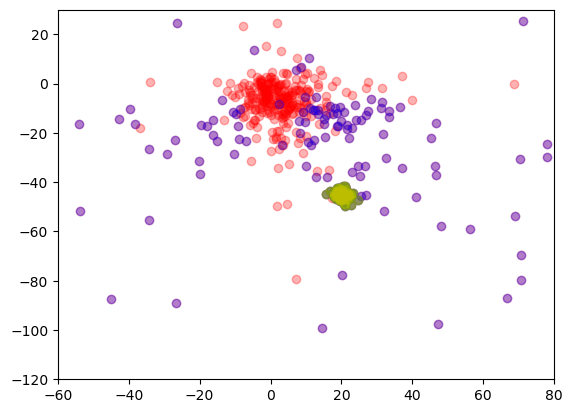

In [19]:
plt.scatter(r['pmra'], r['pmdec'], color='r', alpha=0.3)
plt.scatter(j['pmra'], j['pmdec'], color='b', alpha=0.3)
plt.scatter(m45cluster['pmra'], m45cluster['pmdec'], color='g', alpha=0.3)
plt.scatter(test['pmra'], test['pmdec'], color='y', alpha=0.3)
plt.xlim(-60,80)
plt.ylim(-120,30)

plt.show()